<a href="https://colab.research.google.com/github/TheAmirHK/Financial-market-analysis/blob/main/Stock%20price%20forecasting_Geometric_Brownian_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" Using a physics-based simualtion model so-caled Geometric Brownian Motion model to simulate the future value of a stock price.
Geometric Brownian Motion (GBM) model forms the basis for the Black–Scholes equation where the log returns of stock prices is modelled: the main interest is in the option pricing of derivatives.
GBM has two components; a drift of the stock which represents the return that the stock will earn over a short period of time.
And, a stochastic process including the stocks volatility and an element of random volatility """

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error, r2_score, mean_absolute_error

from scipy.stats import norm, gmean, cauchy

# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The stocks to be analyzed !
stock = ["AAPL"]

# define the number of year to be studied
NYears = 5

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
# Download stock data
data = pdr.get_data_yahoo(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Define train and valid data
def split_data (data , test_size= None, split_date=None):

    input = pd.DataFrame(data)
    input["date"]= input.index
    input = input.set_index('date')
    input = input.reset_index(drop=True)

    if ((split_date is not None) and (test_size is None)):
      split_date = pd.Timestamp(split_date)
      train  = input[: split_date].dropna()
      valid = input[split_date : ].dropna()

    elif ((split_date is None) and (test_size is not None)):
      train, valid = train_test_split(input, test_size=test_size, shuffle=False)

    return train, valid

In [4]:
# Evalute daily return
def log_return(data):
    return data.pct_change().dropna()

In [5]:

# Evaluate the drift in price
def evaluate_drift(data):
    log_data = log_return(data)
    mean = log_data.mean()
    var = log_data.var()
    drift = mean - var/2
    return drift

In [6]:
# Define the simulation
def Brownian_motion (data,valid , days, NMC):
    """
    Inputs:
    data = Old prices
    valid = Old prices for model validation
    days = Number of days to be predicted
    NMC = Number of simulation

    Output:
    Simulation plot
    MAPE = mean absolute percentage error of the simulation
    """
    last_price = data.iloc[-1]
    ft = evaluate_drift(data)
    stv = log_return(data).std()
    real_price = data[-10:-1]
    valid = valid.reset_index()
    # This distribution is called cauchy distribution
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, NMC)))

    price_list = np.zeros((days, NMC))
    price_list[0] = last_price
    for iter in range(1 , days):
        price_list[iter] = price_list[iter-1]*dr[iter]
    price_list = pd.DataFrame(price_list)
    MAPE = mean_absolute_percentage_error(price_list.mean(axis=1), valid['Adj Close'])
    print("Brownian motion MAPE %0.3f"%MAPE)
    fig = sns.lineplot(price_list, legend = False, linewidth = 1 )
    fig = sns.lineplot(valid['Adj Close'], label= "Valid price", linewidth = 3)
    return MAPE

Brownian motion MAPE 0.067


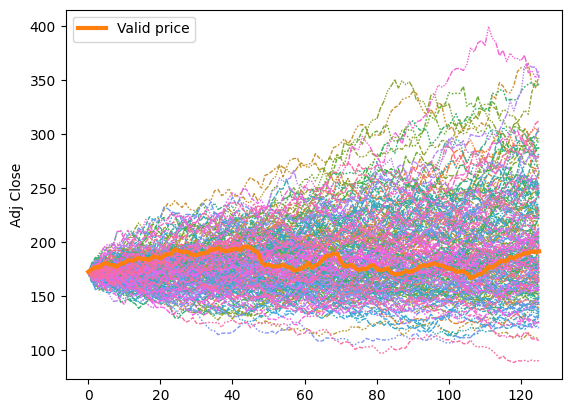

In [7]:
train_set = data["Adj Close"]
train, valid = split_data (train_set , test_size= 0.1, split_date=None)
days = len(valid)
BM_MAPE = Brownian_motion(train['Adj Close'],valid ,  days, 200)